<a href="https://colab.research.google.com/github/SalimZ04/UAV_MCV/blob/main/ortools_demo_logistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from ortools.sat.python import cp_model # CP-SAT solver

import numpy as np
from random import randint
from math import ceil
import matplotlib.pyplot as plt # Data visualization
plt.rcParams["figure.figsize"] = (15,10)

     |████████████████████████████████| 28.9MB 135kB/s 
     |████████████████████████████████| 1.3MB 38.2MB/s 
  Found existing installation: protobuf 3.10.0
    Uninstalling protobuf-3.10.0:
      Successfully uninstalled protobuf-3.10.0


# Parameters

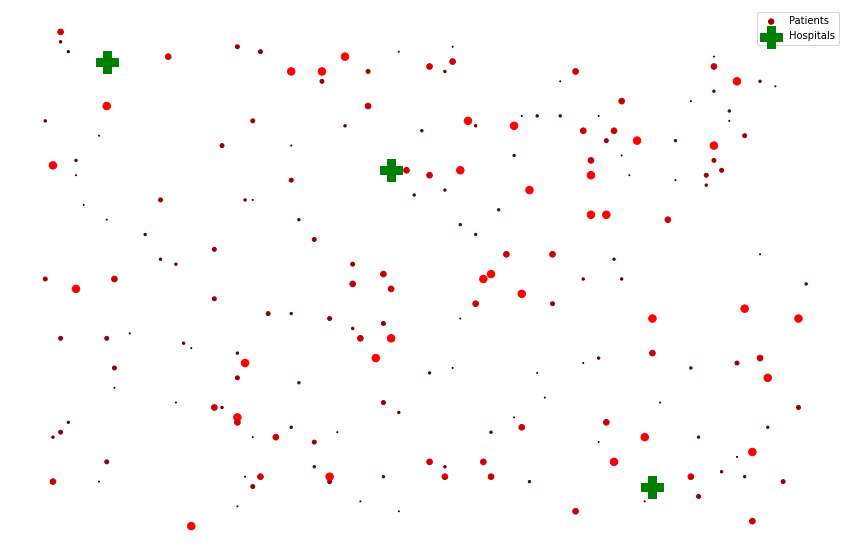

In [ ]:
# Number of hospitals
n_hospitals = 3
# Number of patients
n_patients = 200
# Number of beds in every hospital
n_beds_in_hospitals = [30,40,15]
# Total number of beds
n_beds_total = sum(n_beds_in_hospitals)
# Location of patients -- random integer tuple (x,y)
patients_loc = [(randint(0, 100), randint(0, 100)) for _ in range(n_patients)]
# Location of hospitals -- random integer tuple (x,y)
hospitals_loc = [(randint(0, 100), randint(0, 100)) for _ in range(n_hospitals)]  
# Illness severity -- 1 = mild -> 5 = severe
patients_severity = [randint(1, 5) for _ in range(n_patients)]

# Visualization
shade_severity = [int(sev*255/5) for sev in patients_severity]
color_severity = ["#%02x0000" % (sev) for sev in shade_severity]
size_severity = [k**2.5 for k in patients_severity]
plt.scatter(*zip(*patients_loc), s=size_severity, c=color_severity, label="Patients")
plt.scatter(*zip(*hospitals_loc), s=500, c="g", marker="P", label="Hospitals")
plt.legend()
plt.axis('off')
plt.show()       

# Model variables



In [ ]:
model = cp_model.CpModel()
x = {}
for i in range(n_hospitals):
  for j in range(n_beds_in_hospitals[i]):
    for k in range(n_patients):
      x[(i,j,k)] = model.NewBoolVar("x(%d,%d,%d)" % (i,j,k))

# Hard constraints

In [ ]:
# Each bed must host at most one person
for i in range(n_hospitals):
  for j in range(n_beds_in_hospitals[i]):
    model.Add(sum(x[(i,j,k)] for k in range(n_patients)) <= 1)
      

# Each person must be placed in at most one bed
for k in range(n_patients):
  inner_sum = []
  for i in range(n_hospitals):
    inner_sum.append(sum(x[(i,j,k)] for j in range(n_beds_in_hospitals[i]))) 
  model.Add(sum(inner_sum) <= 1)

# Soft constraints

In [ ]:
# Integer distance function
idist = lambda xy1, xy2: int(((xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2)**0.5)

# Gain factors (1/penalty factors)
gain_max_patients = 140
gain_severity = int(140/5)
gain_distance = -1

# Maximization objective
soft_csts = []
for i in range(n_hospitals):
  for j in range(n_beds_in_hospitals[i]):
    for k in range(n_patients):
      factor = \
        gain_max_patients \
        + gain_distance * idist(hospitals_loc[i], patients_loc[k]) \
        + gain_severity * patients_severity[k]
      soft_csts.append(factor * x[(i,j,k)])

model.Maximize(sum(soft_csts))

# Solving model

In [ ]:
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 60.0
status = solver.Solve(model)

# Priting results

In [ ]:
plot_lines = [[] for _ in range(n_hospitals)]
for i in range(n_hospitals):
  print("Hospital ", i)
  for j in range(n_beds_in_hospitals[i]):
    for k in range(n_patients):
      if solver.Value(x[(i,j,k)]) == 1:
        print("\tPatient ", k, "in bed ", j)
        line_abs = [ hospitals_loc[i][0], patients_loc[k][0] ]
        line_ord = [ hospitals_loc[i][1], patients_loc[k][1] ]
        plot_lines[i].append([line_abs, line_ord])
print()
print("Inference time: %f s" % solver.WallTime())

Hospital  0
	Patient  51 in bed  0
	Patient  123 in bed  1
	Patient  39 in bed  2
	Patient  105 in bed  3
	Patient  6 in bed  4
	Patient  157 in bed  5
	Patient  193 in bed  6
	Patient  40 in bed  7
	Patient  69 in bed  8
	Patient  88 in bed  9
	Patient  21 in bed  10
	Patient  107 in bed  11
	Patient  106 in bed  12
	Patient  156 in bed  13
	Patient  0 in bed  14
	Patient  11 in bed  15
	Patient  84 in bed  16
	Patient  77 in bed  17
	Patient  168 in bed  18
	Patient  141 in bed  19
	Patient  122 in bed  20
	Patient  155 in bed  21
	Patient  9 in bed  22
	Patient  179 in bed  23
	Patient  53 in bed  24
	Patient  30 in bed  25
	Patient  54 in bed  26
	Patient  188 in bed  27
	Patient  136 in bed  28
	Patient  112 in bed  29
Hospital  1
	Patient  91 in bed  0
	Patient  4 in bed  1
	Patient  145 in bed  2
	Patient  94 in bed  3
	Patient  78 in bed  4
	Patient  137 in bed  5
	Patient  67 in bed  6
	Patient  161 in bed  7
	Patient  198 in bed  8
	Patient  100 in bed  9
	Patient  18 in bed 

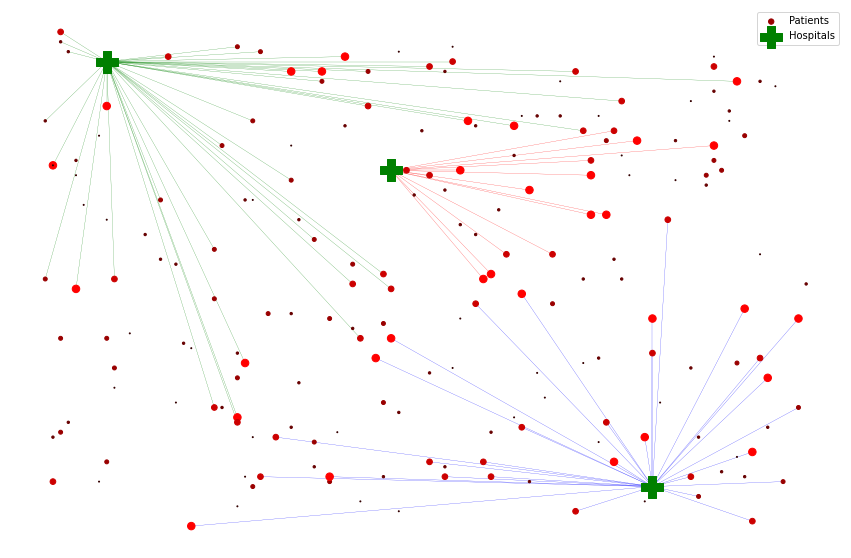

In [ ]:
from itertools import cycle

shade_severity = [int(sev*255/5) for sev in patients_severity]
color_severity = ["#%02x0000" % (sev) for sev in shade_severity]
size_severity = [k**2.5 for k in patients_severity]
plt.scatter(*zip(*patients_loc), s=size_severity, c=color_severity, label="Patients", zorder=2)
plt.scatter(*zip(*hospitals_loc), s=500, c="g", marker="P", label="Hospitals", zorder=3)
colors = cycle('bgrcmk')
for i in range(n_hospitals):
  c = next(colors)
  for (x_,y_) in plot_lines[i]:
    plt.plot(x_,y_,c=c,linewidth=0.2, zorder=1)
plt.legend()
plt.axis('off')
plt.show()       